# Figure 4 – Sequencing of TP53 validates the prime editing sensor approach.
## Figure 4a

Schematic of the sequencing of the TP53 locus. Regions within exons 6, 7, and 10 were sequenced from genomic DNA extracted at Day 4 and Day 34 in the untreated and Nutlin-treated arm of the screen.

In [28]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Bio.Seq
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
import scipy.stats
plt.rc('font', family='Helvetica')

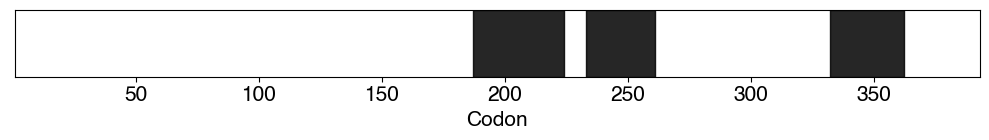

In [29]:
amp_locs = [[332, 362], [187, 224], [233, 261]]

mat1 = np.zeros(393)

fig, ax = plt.subplots(figsize=(10,1.5))

for i in amp_locs:

    ax.axvspan(i[0],i[1], alpha=0.85, color='black')

ax.set_xlim(1,393)
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Codon', fontsize=15)

fig.tight_layout()

## Figure 4b

Correlation between the LFC in pegRNA counts and the LFC of endogenous variants at the TP53 locus for Day 34 vs. Day 4 of the untreated arm of the screen at different thresholds of pegRNA editing activity.

In [30]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Bio.Seq
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
import scipy.stats
plt.rc('font', family='Helvetica')

In [31]:
#reading in MAGeCK-analyzed endogenous sequencing datasets
files = os.listdir('./MAGeCK analysis/MAGeCK endogenous sequencing/mageck_output/')

lfc_tables = sorted([i for i in files if 'sgrna' in i])

lfc = []
for i in lfc_tables:
    k = pd.read_csv(f'./MAGeCK analysis/MAGeCK endogenous sequencing/mageck_output/{i}', sep='\t').sort_values(by='LFC', ascending=False).reset_index().drop(columns='index')
    lfc.append(k)

#formatting and concatenating results from different amplicons
d34_lfc = [lfc[0], lfc[2], lfc[4]]
d34_nut_lfc = [lfc[1], lfc[3], lfc[5]]

for i, val in enumerate(d34_lfc):
    val['amplicon'] = i + 1

for i, val in enumerate(d34_nut_lfc):
    val['amplicon'] = i + 1

d34_endogenous = pd.concat((lfc[0], lfc[2], lfc[4])).rename(columns = {'treatment_count':'treatment_count_endogenous', 
                                                                       'control_count': 'control_count_endogenous',
                                                                       'LFC':'LFC_endogenous', 
                                                                       'Gene':'HGVSp'})

d34_nut_endogenous = pd.concat((lfc[1], lfc[3], lfc[5])).rename(columns = {'treatment_count':'treatment_count_endogenous', 
                                                                       'control_count': 'control_count_endogenous',
                                                                       'LFC':'LFC_endogenous', 
                                                                       'Gene':'HGVSp'})

In [32]:
#reading in MAGeCK analysis of pegRNA-sensor counts + sensor editing quantification
#reading the MAGeCK results into a dictionary
#and also reading in information about correct editing percentage

#loading in the data
p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')


#loading in the merged replicates to boost confidence on sensor
fp = "crispresso_replicates_merged"
reorder = []
conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']
for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))
samps = list(cp_dict2.keys())[1:]


#reading in mageck
fp = './MAGeCK analysis'
files = os.listdir(fp)
files = sorted([f for f in files if f[-3:]=='txt'])

dfs = []
for i,f in enumerate(files):
    df = pd.read_csv(fp + '/' + f, sep='\t')

    #ensure naming is correct
    assert f[:3]==samps[i][:3]

    #reorder the pegs...
    df = df.rename(columns = {'sgrna':'peg_id'})
    df_merge = pd.merge(p53_filtered, df, how='left', on='peg_id')

    #also add in merge of cp_dict?

    dfs.append(df_merge)


#perform thresholding of control_mean counts (filtering out pegRNAs with below 10 control counts mean)
#differences in counts because of normalization
#going to do it for one and apply it to all...

control_mean_threshold = 10

#d16
dd = dfs[0]
dd = dd[dd['control_mean']>=control_mean_threshold]
pegs_above_thres = dd['peg_id']

dfs2 = []
for i in dfs:
    dfs2.append(i[i['peg_id'].isin(pegs_above_thres)])


assert list(dfs2[0]['peg_id']) == list(dfs2[1]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[2]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[3]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[4]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[5]['peg_id']) 

mageck_dict = dict(zip(samps, dfs2))

In [33]:
#merging the endogenous and pegRNA sequencing MAGeCK analyses for downstream comparison

#D34
sample = 'D34'
counts_threshold=10 #minimum number of sensor reads for inclusion
corr_perc_min = 0
corr_perc_max = 100

bb = mageck_dict[sample].copy()
bb = bb.replace(0,1e-5) #for the log FDR calculation
bb['-log10(FDR)']=-np.log10(bb['FDR'])

d34 = cp_dict2[sample]
d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]
p = d34[(d34['corr_perc_backsub']>=corr_perc_min) & (d34['corr_perc_backsub']<=corr_perc_max)]

d34 = pd.merge(bb, p, on='peg_id')

#D34 + Nutlin
sample = 'D34-NUT'

bb = mageck_dict[sample].copy()
bb = bb.replace(0,1e-5) #for the log FDR calculation
bb['-log10(FDR)']=-np.log10(bb['FDR'])

d341 = cp_dict2[sample]
d341 = d341[d341['Reads_aligned_all_amplicons']>=counts_threshold]
p = d341[(d341['corr_perc_backsub']>=corr_perc_min) & (d341['corr_perc_backsub']<=corr_perc_max)]

d34_nut = pd.merge(bb, p, on='peg_id')

#selecting pertinent columns from endogenous sequencing
pertinent_cols = ['HGVSp', 'control_count_endogenous','treatment_count_endogenous','LFC_endogenous', 'amplicon']

d34_endogenous = d34_endogenous[pertinent_cols]
d34_nut_endogenous = d34_nut_endogenous[pertinent_cols]

#and merging dataframes
d34_merged = pd.merge(d34, d34_endogenous, on='HGVSp')
d34_nut_merged = pd.merge(d34_nut, d34_nut_endogenous, on='HGVSp')


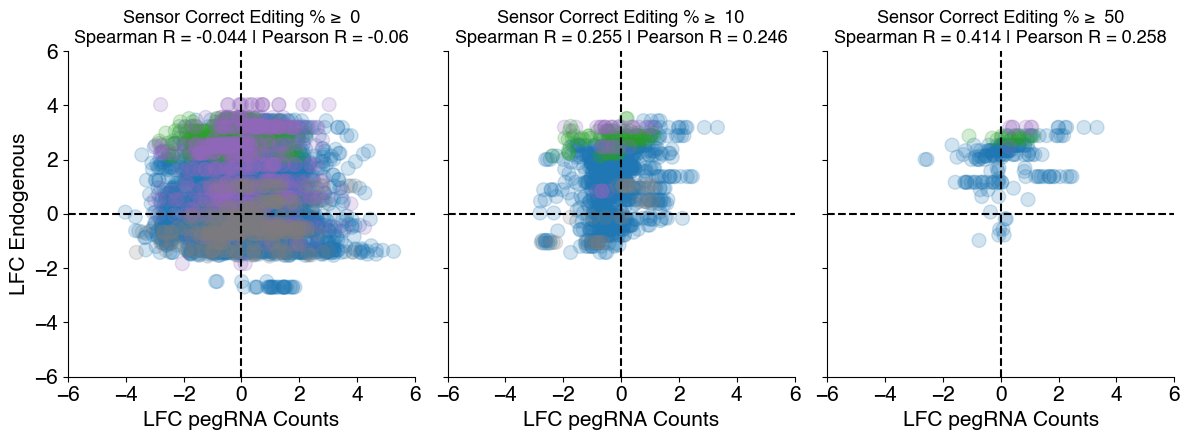

In [34]:
#generating the comparison figure
dm = d34_merged.copy()

min_control_counts = 10
dm = dm[dm['control_count_endogenous']>=min_control_counts]

fig, ax = plt.subplots(nrows=1, ncols = 3, figsize=(12,4.5), sharey=True, sharex=True)

l1 = [0,10,50]

#for variant coloring
mut = []
for idx, val in dm.iterrows():
    type1 = val['variant_type']
    conseq = val['consequence']
    if conseq in ['Silent']:
        mut.append(conseq)
    else:
        mut.append(type1)


dm['mut'] = mut

for i, val in enumerate(l1):
    corr_perc_min = val
    corr_perc_max = 100

    dm = dm[(dm['corr_perc_backsub']>=corr_perc_min) & (dm['corr_perc_backsub']<=corr_perc_max)]

    spear = np.round(scipy.stats.spearmanr(dm['LFC'], dm['LFC_endogenous']).statistic, 3)
    pear = np.round(scipy.stats.pearsonr(dm['LFC'], dm['LFC_endogenous']).statistic, 3)
    
    c_dict = dict(zip(['SNV', 'INS', 'DEL', 'Silent'], ['tab:blue', 'tab:green', 'tab:purple', 'tab:grey']))



    color1 = [c_dict[i] for i in dm['mut']]

    ax[i].scatter(dm['LFC'], dm['LFC_endogenous'], color=color1, alpha=.2, s=100)

    ax[i].plot([-6,6],[0,0],linestyle='dashed',color='black', )
    ax[i].plot([0,0],[-6,6],linestyle='dashed',color='black', )


    ax[i].set_xlabel('LFC pegRNA Counts', fontsize=15)
    ax[0].set_ylabel('LFC Endogenous', fontsize=15)
    ax[i].set_title(f'Sensor Correct Editing % ≥  {corr_perc_min}\nSpearman R = {spear} | Pearson R = {pear}', fontsize=13)

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].tick_params(axis='both', which='major', labelsize=15)

    ax[i].set_xlim(-6,6)
    ax[i].set_ylim(-6,6)
    ax[i].set_xticks([-6,-4,-2,0,2,4,6])

    if i>=10:
        bb2 = dm[(dm['LFC']>=3.75)]
        bb3 = dm[dm['LFC_endogenous']<=-3]
        bb2 = pd.concat((bb2, bb3))
        x = list(bb2['LFC'])
        y = list(bb2['LFC_endogenous'])
        t = list(bb2['HGVSp'])
        c = list(bb2['mut'])
        #adjust_text(texts, x, y, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

        c_dict = {'SNV':'darkblue', 'INS':'darkgreen', 'DEL':'tab:purple', 'Silent':'grey'}

        texts = [ax[i].text(x[k], y[k], t[k], fontsize=12, color=c_dict[c[k]], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                        foreground="w")]) for k in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


        adjust_text(texts,only_move={'points':'y', 'texts':'xy'}, ax=ax[i], arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))

    else:
        continue


fig.tight_layout()

## Figure 4c

Correlation between the LFC in pegRNA counts and the LFC of endogenous variants at the TP53 locus for Day 34 vs. Day 4 of the Nutlin-treated arm of the screen at different thresholds of pegRNA editing activity.

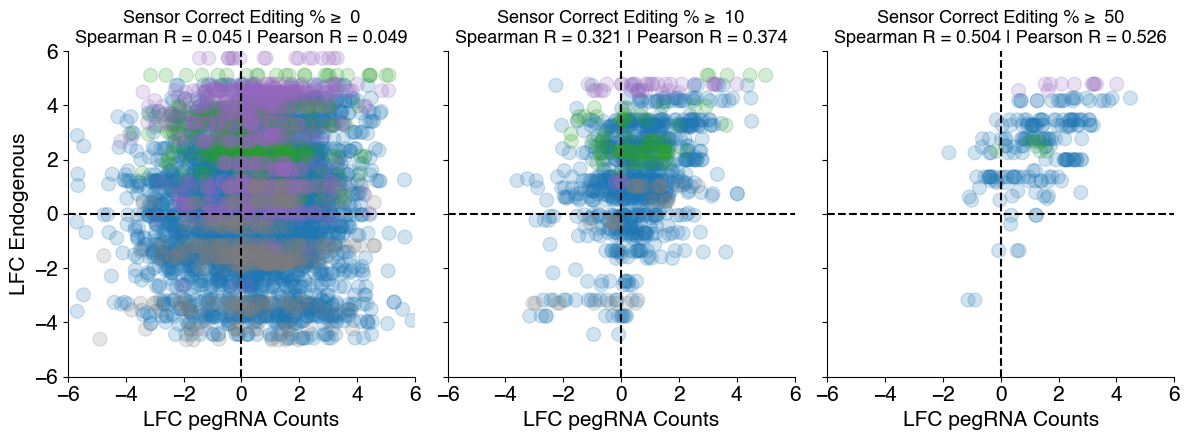

In [35]:
#generating the plot from data above
dm = d34_nut_merged.copy()

min_control_counts = 10
dm = dm[dm['control_count_endogenous']>=min_control_counts]

fig, ax = plt.subplots(nrows=1, ncols = 3, figsize=(12,4.5), sharey=True, sharex=True)

l1 = [0,10,50]

#for variant coloring
mut = []
for idx, val in dm.iterrows():
    type1 = val['variant_type']
    conseq = val['consequence']
    if conseq in ['Silent']:
        mut.append(conseq)
    else:
        mut.append(type1)


dm['mut'] = mut

for i, val in enumerate(l1):
    corr_perc_min = val
    corr_perc_max = 100

    dm = dm[(dm['corr_perc_backsub']>=corr_perc_min) & (dm['corr_perc_backsub']<=corr_perc_max)]

    spear = np.round(scipy.stats.spearmanr(dm['LFC'], dm['LFC_endogenous']).statistic, 3)
    pear = np.round(scipy.stats.pearsonr(dm['LFC'], dm['LFC_endogenous']).statistic, 3)
    
    c_dict = dict(zip(['SNV', 'INS', 'DEL', 'Silent'], ['tab:blue', 'tab:green', 'tab:purple', 'tab:grey']))



    color1 = [c_dict[i] for i in dm['mut']]

    ax[i].scatter(dm['LFC'], dm['LFC_endogenous'], color=color1, alpha=.2, s=100)

    ax[i].plot([-6,6],[0,0],linestyle='dashed',color='black', )
    ax[i].plot([0,0],[-6,6],linestyle='dashed',color='black', )


    ax[i].set_xlabel('LFC pegRNA Counts', fontsize=15)
    ax[0].set_ylabel('LFC Endogenous', fontsize=15)
    ax[i].set_title(f'Sensor Correct Editing % ≥  {corr_perc_min}\nSpearman R = {spear} | Pearson R = {pear}', fontsize=13)

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].tick_params(axis='both', which='major', labelsize=15)

    ax[i].set_xlim(-6,6)
    ax[i].set_ylim(-6,6)
    ax[i].set_xticks([-6,-4,-2,0,2,4,6])

    if i>=10:
        bb2 = dm[(dm['LFC']>=3.75)]
        bb3 = dm[dm['LFC_endogenous']<=-3]
        bb2 = pd.concat((bb2, bb3))
        x = list(bb2['LFC'])
        y = list(bb2['LFC_endogenous'])
        t = list(bb2['HGVSp'])
        c = list(bb2['mut'])
        #adjust_text(texts, x, y, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

        c_dict = {'SNV':'darkblue', 'INS':'darkgreen', 'DEL':'tab:purple', 'Silent':'grey'}

        texts = [ax[i].text(x[k], y[k], t[k], fontsize=12, color=c_dict[c[k]], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                        foreground="w")]) for k in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


        adjust_text(texts,only_move={'points':'y', 'texts':'xy'}, ax=ax[i], arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))

    else:
        continue


fig.tight_layout()

## Figure 4d

Spearman correlation between the LFC in pegRNA counts and the LFC of endogenous variants at the TP53 locus as a function of the minimum sensor correct editing threshold for Day 34 untreated (blue) and D34 Nutlin-treated (red) samples.

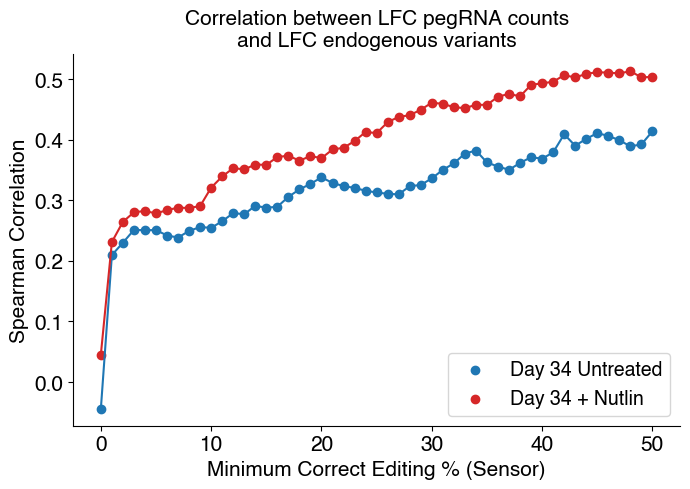

In [36]:
dm = d34_merged.copy()
dm_nut = d34_nut_merged.copy()

min_control_counts = 10
dm = dm[dm['control_count_endogenous']>=min_control_counts]
dm_nut = dm_nut[dm_nut['control_count_endogenous']>=min_control_counts]

l1 = [0,10,20,30,40,50]

spear_untreat = []
pear_untreat = []
spear_nutlin = []
pear_nutlin = []

y = np.linspace(0,50,51)

for i in y:
    corr_perc_min = i
    corr_perc_max = 100

    dm = dm[(dm['corr_perc_backsub']>=corr_perc_min) & (dm['corr_perc_backsub']<=corr_perc_max)]
    spear1 = scipy.stats.spearmanr(dm['LFC'], dm['LFC_endogenous']).statistic
    pear1 = scipy.stats.pearsonr(dm['LFC'], dm['LFC_endogenous']).statistic

    dm_nut = dm_nut[(dm_nut['corr_perc_backsub']>=corr_perc_min) & (dm_nut['corr_perc_backsub']<=corr_perc_max)]
    spear2 = scipy.stats.spearmanr(dm_nut['LFC'], dm_nut['LFC_endogenous']).statistic
    pear2 = scipy.stats.pearsonr(dm_nut['LFC'], dm_nut['LFC_endogenous']).statistic

    spear_untreat.append(spear1)
    pear_untreat.append(pear1)

    spear_nutlin.append(spear2)
    pear_nutlin.append(pear2)

fig, ax = plt.subplots(figsize=(7,5))


ax.plot(y,spear_untreat, color='tab:blue')
ax.plot(y,spear_nutlin, color='tab:red')
ax.scatter(y, spear_untreat, color='tab:blue', label='Day 34 Untreated')
ax.scatter(y, spear_nutlin, color='tab:red', label='Day 34 + Nutlin')
ax.legend(fontsize=14, loc='lower right')
#ax.set_ylim(0,)

ax.set_xlabel('Minimum Correct Editing % (Sensor)', fontsize=15)
ax.set_ylabel('Spearman Correlation', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.set_xlim(-.1,5)
ax.set_title('Correlation between LFC pegRNA counts\nand LFC endogenous variants', fontsize=15)
fig.tight_layout()


## Figure 4e

The percentage of variants detected (≥ 500 counts) at the TP53 locus at Day 34 (untreated) for variants with pegRNAs at different minimum sensor correct editing thresholds.  


In [37]:
#reading in raw counts files and merging different amplicons

a = pd.read_csv('MAGeCK analysis/MAGeCK endogenous sequencing/df1_mageck.txt', sep='\t').rename(columns = {'sgRNA':'HGVSp', 'D4-REP1':'D4', 'D34-REP1':'D34', 'D34-Nutlin-REP1':'D34-Nutlin'})
b = pd.read_csv('MAGeCK analysis/MAGeCK endogenous sequencing/df2_mageck.txt', sep='\t').rename(columns = {'sgRNA':'HGVSp','D4-REP2':'D4','D34-REP2':'D34', 'D34-Nutlin-REP2':'D34-Nutlin'})
c = pd.read_csv('MAGeCK analysis/MAGeCK endogenous sequencing/df3_mageck.txt', sep='\t').rename(columns = {'sgRNA':'HGVSp','D4-REP3':'D4','D34-REP3':'D34', 'D34-Nutlin-REP3':'D34-Nutlin'})

raw = pd.concat((a,b,c))
raw = raw[raw['HGVSp']!='WT']

#cutoff for detection; this is relatively stringent and could be reduced
cutoff = 500
raw = raw[raw['D34']>=cutoff]
raw

,HGVSp,gene,D4,D34,D34-Nutlin
1,R213Q,R213Q,88919.0,85232.0,96951.0
2,V217M,V217M,29508.0,27707.0,33308.0
3,G199V,G199V,28725.0,6153.0,36406.0
4,P222P,P222P,27911.0,28775.0,42491.0
5,S215G,S215G,23825.0,22724.0,25419.0
...,...,...,...,...,...
58,L348Ter,L348Ter,137.0,1540.0,4290.0
59,F341C,F341C,103.0,791.0,2190.0
61,R333VfsTer12,R333VfsTer12,86.0,1170.0,8079.0
66,E339VfsTer8,E339VfsTer8,36.0,542.0,835.0


In [38]:
#selecting the subset of pegRNAs targeting variants that fall within the sequenced regions
inc_codons = list(range(332, 363)) + list(range(187,225)) + list(range(233,262))
d34_x = d34[d34['codon'].isin(inc_codons)]

uniq_hgs = []
for cp_min in range(16):
    d34_cutoff1 = np.unique(d34_x[d34_x['corr_perc_backsub']>=cp_min]['HGVSp'])
    uniq_hgs.append(d34_cutoff1)


counter = np.zeros(16)
for i, val in raw.iterrows():
    hg = val['HGVSp']
    
    for i, val in enumerate(uniq_hgs):
        if hg in val:
            counter[i]+=1

counter = 100*counter/np.array([len(i) for i in uniq_hgs])

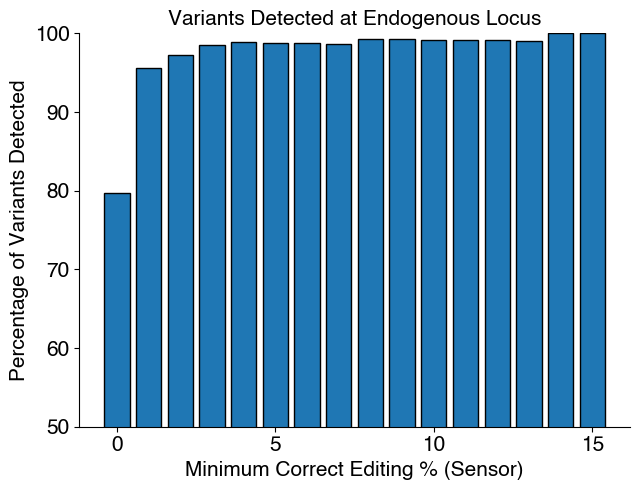

In [39]:
#and plotting
fig, ax = plt.subplots(figsize=(6.5,5))


ax.set_xlabel('Minimum Correct Editing % (Sensor)', fontsize=15)
ax.set_ylabel('Percentage of Variants Detected', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.set_xlim(-.1,5)
ax.set_title('Variants Detected at Endogenous Locus', fontsize=15)

ax.bar(range(len(counter)), counter, linewidth=1, edgecolor='black')
#ax.scatter(range(len(counter)), counter, color='black')

#ax.plot(range(len(counter)), counter, color='black')
#ax.set_xticks([0,1,2,3])
#ax.set_xticklabels([0,1,10,30])
ax.set_xticks([0,5,10,15])
ax.set_ylim(50,100)

fig.tight_layout()